# Logistic regression

For each word count how many times it is used in good and bad jokes (positive and negative frequency). For each joke some up this frequencies for all words (except stop words). Use logistic regression to classify jokes based on these features.

In [29]:
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import LoadIndices, LoadDatasets

import logging

import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("russian"))

from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Load datasets
an_jokes, bash_jokes = LoadDatasets()

# Load direct and inverted indices
an_direct, an_inverted, bash_direct, bash_inverted = LoadIndices()

## Anecdotes classification

In [31]:
# Train and test samples indices
def TrainTestIdx(jokes, train_share = 0.75):
    N = len(jokes)
    good_idx = np.array([i for i in range(N) if jokes[i][-1]])
    bad_idx = np.array([i for i in range(N) if not jokes[i][-1]])
    np.random.shuffle(good_idx)
    np.random.shuffle(bad_idx)
    N_good = len(good_idx)
    N_bad = len(bad_idx)
    N_train_good = int(train_share * N_good)
    N_train_bad = int(train_share * N_bad)
    N_test_good = N_good - N_train_good
    N_test_good = N_bad - N_train_good
    train_good_idx = good_idx[:N_train_good]
    test_good_idx = good_idx[N_train_good:]
    train_bad_idx = bad_idx[:N_train_bad]
    test_bad_idx = bad_idx[N_train_bad:]
    return train_good_idx, train_bad_idx, test_good_idx, test_bad_idx

train_good_idx, train_bad_idx, test_good_idx, test_bad_idx = TrainTestIdx(an_jokes)

# How many times each word met in good and bad jokes
def getFreq(direct_index, idx):
    freq = {}
    for i in idx:
        d = direct_index[i]
        for w in d:
            if w not in stopwords:
                freq[w] = freq.get(w, 0) + d[w]
    return freq

freq_good = getFreq(an_direct, train_good_idx)
freq_bad = getFreq(an_direct, train_bad_idx)

def ModelData(good_idx, bad_idx, data = 'anec'):
    if data == 'anec':
        direct = an_direct
    elif data == 'bash':
        direct = bash_direct
    else:
        logging.error("Unknown data: {}".format(data))
        return
    N_good = len(good_idx)
    N_bad = len(bad_idx)
    X = np.zeros((N_good + N_bad, 3))
    y = np.zeros(N_good + N_bad)
    X[:,0] = 1
    for n in range(N_good):
        i = good_idx[n]
        for w in direct[i]:
            X[n,1] += freq_good.get(w, 0)
            X[n,2] += freq_bad.get(w, 0)
            y[n] = 1.0
    for n in range(N_bad):
        i = bad_idx[n]
        for w in direct[i]:
            X[N_good+n,1] += freq_good.get(w, 0)
            X[N_good+n,2] += freq_bad.get(w, 0)
            y[N_good+n] = 0.0
    return X, y

X, y = ModelData(train_good_idx, train_bad_idx, 'anec')

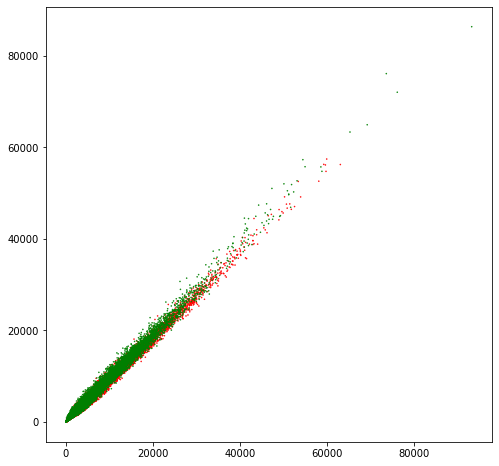

In [32]:
fig = plt.figure(figsize = (8,8))
colors = ['green', 'red']
plt.scatter(X[:,1], X[:,2], c = [colors[int(k)] for k in y], s = 0.3)

In [33]:
lr = LogisticRegression(penalty = 'none')
lr.fit(X, y)
print("Train accuracy: {:.3f}".format(lr.score(X, y)))

Xtest, y_test = ModelData(test_good_idx, test_bad_idx, 'anec')
print("Test accuracy: {:.3f}".format(lr.score(Xtest, y_test)))

Train accuracy: 0.605
Test accuracy: 0.588


## Bash quotes classification

In [34]:
# Train and test samples indices
train_good_idx, train_bad_idx, test_good_idx, test_bad_idx = TrainTestIdx(bash_jokes)

freq_good = getFreq(bash_direct, train_good_idx)
freq_bad = getFreq(bash_direct, train_bad_idx)

X, y = ModelData(train_good_idx, train_bad_idx, 'bash')

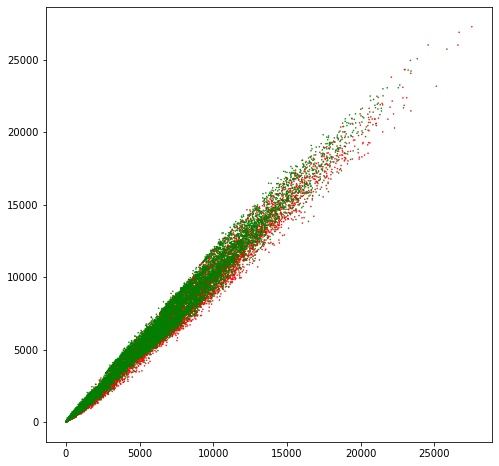

In [35]:
fig = plt.figure(figsize = (8,8))
colors = ['green', 'red']
plt.scatter(X[:,1], X[:,2], c = [colors[int(k)] for k in y], s = 0.3)

In [36]:
lr = LogisticRegression(penalty = 'none')
lr.fit(X, y)
print("Train accuracy: {:.3f}".format(lr.score(X, y)))

Xtest, y_test = ModelData(test_good_idx, test_bad_idx, 'bash')
print("Test accuracy: {:.3f}".format(lr.score(Xtest, y_test)))

Train accuracy: 0.590
Test accuracy: 0.576
